In [1]:
import sys
sys.path.append('..')
import nbimport 
nbimport.initialize()

In [2]:
from Stat_19 import *
css_styling()

# Simultan kurvetilpasning i regioner

# Simultaneous curve fitting in regions

## Formål 

- At kunne foretage samtidige maksimal sandsynlighedsestimater over flere områder (_channels_)
- At forstå styrken og ulemperne ved denne metode 

## Purpose

- Being able to make simultaneous maximum likelihood estimates across multiple regions (_channels_)
- Understand the strengths and disadvantages of this method

## Problemet 

En ofte brugt teknik i data behandling, særligt i eksperimentel høj energi partikelfysik, er simultan tilpasningover flere data regioner.   Vi kan tænke os følgende senarie: 

- Vi har en model eller målinger som forudsiger et bestemt signal i et bestemt område (region eller _channel_).
  Det kan f.eks. være massen af en postuleret partikel i det [invariante massespektrum](https://en.wikipedia.org/wiki/Invariant_mass)
- I andre områder forudsiger model andre eller ingen signaler. 
- Desuden har vi modeler eller andre forudsigelser for baggrunden i vores observationer.  
- Baggrunden kendes måske godt i et område men mindre godt i andre

Vi vil nu gerne finde ud af om vores data er konsistent med det postuleret signal.  Vi vil bruge et område til at få styr på vores model for baggrund og eventuelt kendte signaler mens at vi vil søge efter signalet i et andet område. 



## The problem

A commonly used technique in data processing, especially in experimental high energy particle physics, is simultaneous fitting across multiple data regions. We can imagine the following scenario:

- We have a model or measurements that predict a particular signal in a specific area (region or _channel_).
  It can for example. be the mass of a postulated particle in the [invariant mass spectrum](https://en.wikipedia.org/wiki/Invariant_mass).
- In other areas, the model predicts other or no signals.
- In addition, we have models or other predictions for the background of our observations.
- The background may be well known in one area but less well known in others

We would now like to find out if our data is consistent with the postulated signal. We will use one area to control our model for background and possibly known signals while we will search for the signal in another area.

## Brug af EB-MLE

## Using EB-MLE

Vi vil arbejde ud fra et konkret eksempel i dette kapitel.  Vi vil dog stadig udvikle generelle teknikker der kan bruges i andre tilfælde. 

We will work from a concrete example in this chapter. However, we will still develop general techniques that can be used in other cases.

### Eksempel: To kanaler

### Example: Two channels

Lad os først og fremmest lave noget data.  Vi starter med at sætte et _seed_. 

First of all, let's make some data. We start by setting the _seed_.

In [3]:
from numpy.random import seed 

seed(1234)

#### Første kanal 

Vi starter med en region hvor vi har 

- En flad baggrund $B_{1,1}$
- En anden flad baggrund i halvdelen af intervallet  $B_{1,2}$
- Et (kendt) normal fordelt signal $S_1$

#### First channel

We start with a region where we have

- A flat background $B_{1,1}$
- Another flat background over half the interval $B_{1,2}$
- A (known) normal distributed signal $S_1$

Først de bøtter vi vil putte data i

First, the bins we want to put data into

In [4]:
from numpy import linspace

r1_b = linspace(0,10,11)
r1_x = (r1_b[1:]+r1_b[:-1])/2

Da vi vil lave histogram PDF'er af vores fordelinger laver vi en simple funktion til at give os disse, og samtidig holde koden klar og kort

Since we want to make histogram PDFs of our distributions, we do a simple function to provide these, while keeping the code clear and short

In [5]:
def make_pdf(bins,sample,overall=None):
    h = histogram(sample,bins)
    
    if overall is not None:
        
        @overall_sys_pdf(overall[0],overall[1])
        @scale_pdf()
        def f(x,hist=histo_pdf(h[1],h[0])):
            return hist(x)
        
    else:
        
        @scale_pdf()
        def f(x,hist=histo_pdf(h[1],h[0])):
            return hist(x)
    
    return h, f

Dernæst laver vi vores baggrunde og signal

Next, we make our backgrounds and signal

In [6]:
from numpy.random import uniform, normal 

bg2_overall = (-.05,+.05)

r1_bg1_h,r1_bg1_f = make_pdf(r1_b,uniform(r1_b[0],r1_b[-1],  size=100))
r1_bg2_h,r1_bg2_f = make_pdf(r1_b,uniform(r1_b[0],r1_b[-1]/2,size=100),overall=bg2_overall)
r1_sg_h, r1_sg_f  = make_pdf(r1_b,normal(2,.1,               size=100))

Vi laver vores data i denne region.  Bemærk at vi laver styrkeforholdene lidt anderledes end i skabelonerne. 

We make our data in this region. Note that we make the strength ratios slightly different from the templates.

In [7]:
from numpy import concatenate

r1_dt_x = concatenate((uniform(r1_b[0],r1_b[-1],  size=50),
                       uniform(r1_b[0],r1_b[-1]/2,size=120),
                       normal(2,.5,               size=30)))
r1_dt_h = histogram(r1_dt_x, r1_b)

Den totale PDF for denne region bliver dermed 

The total PDF for this region thus becomes

In [8]:
def r1_f(x,bg1_scale,bg2_alpha,bg2_scale,sig_scale):
    b1 = r1_bg1_f(x,bg1_scale)
    b2 = r1_bg2_f(x,bg2_alpha,bg2_scale)
    return b1 + b2[0] + r1_sg_f(x,sig_scale), b2[1]

#### Anden kanal 

- En flad baggrund $B_{2,1}$ med samme skalering som $B_{1,1}$
- En eksponentiel baggrund $B_{2,2}$ med samme systematiske usikkerhed som $B_{1,2}$
- Et postuleret normal fordelt signal $S_2$

Vi definerer bøtter og fordelingerne i denne region 

#### Second channel

- A flat background $B_{2,1}$ with the same scaling as $B_{1,1}$
- An exponential background $B_{2,2}$ with the same systematic uncertainty as $B_{1,2}$
- A postulated normal distributed signal $S_2$

We define the bins and the distributions in this region

In [9]:
r2_b = linspace(0,10,11)
r2_x = (r1_b[1:]+r1_b[:-1])/2

from numpy.random import exponential

r2_bg1_h,r2_bg1_f = make_pdf(r2_b,uniform(r2_b[0],r2_b[-1],size=100))
r2_bg2_h,r2_bg2_f = make_pdf(r2_b,exponential(4,           size=100),overall=bg2_overall)
r2_sg_h, r2_sg_f  = make_pdf(r2_b,normal(4,1,              size=100))

Dernæst laver vi vores data og PDF i denne region. 

Next, we create our data and PDF in this region.

In [10]:
r2_dt_x = concatenate((uniform(r2_b[0],r2_b[-1],     size=100),
                      0.5 * uniform(r2_b[0],r2_b[-1],size=150),
                      normal(4,1,                    size=100)))
r2_dt_h = histogram(r2_dt_x, r2_b)

def r2_f(x,bg1_scale,bg2_alpha,bg2_scale,sg_scale):
    b1 = r2_bg1_f(x,bg1_scale)
    b2 = r2_bg2_f(x,bg2_alpha,bg2_scale)
    return b1 + b2[0] + r2_sg_f(x,sg_scale), b2[1]

#### Tilpasning hver for sig 

Inden vi går videre med den samtidige tilpasning forsøger vi os først med en tilpasning i hver kanal for sig.  

#### Fitting separately

Before proceeding with the simultaneous fitting, we first try fitting in each channel separately.

In [11]:
r1_p, r1_c = mle_fit(r1_f,(r1_b,r1_dt_h[0]),(1,1,0,1,1),
                     extended=True,poisson=True)
r2_p, r2_c = mle_fit(r2_f,(r2_b,r2_dt_h[0]),(1,1,0,1,1),
                     extended=True,poisson=True)

Nedenunder tegner vi resultatet. Da vi vil gøre det et par gange skriver vi en lille funktion til at hjælpe os.

Below we draw the result. As we will do this a couple of times, we write a small function to help us. 

In [12]:
p_n = [r'\nu_{R}','A_{B_{R,1}}',r'\alpha_{B_{R,2}}','A_{B_{R,2}}','A_{S_{R}}']

def plot_channel(r,x,bg1,bg2,sg,dt,f,p,cov,off=1,tab=True, pn=p_n):
    gca().set_title(f'Region {r}')

    h_o = lambda c, l : dict(as_bar=True,alpha=.3,color=c,ecolor=c,label=l)

    plot_hist(*bg1,              **h_o('C0',f'$B_{{{r};1}}$'))
    plot_hist(*bg2,bg1[0],       **h_o('C1',f'$B_{{{r};2}}$'))
    plot_hist(*sg, bg1[0]+bg2[0],**h_o('C2',f'$S_{{{r}}}$'))
    plot_hist(*dt, fmt='ok',label='Data')
    plot_fit_func(x, lambda x,*p : f(x,*p)[0], p[off:],cov[off:,off:],
                  color='C5',label='Fit')
    if tab:
        plot_fit_table(p,cov,parameters=[s.replace('R',f'{r}') for s in pn])
    
    gca().legend(loc='center right')

Og nu til plottet. 

And now for the plot.

To regioner, med tilpasning separat i hver region. 

Two regions, with separate fits in each region.

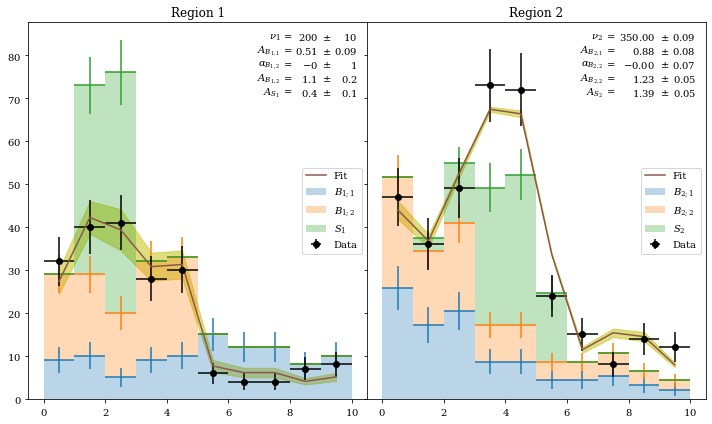

In [13]:
from matplotlib.pyplot import subplots, gca, sca

fig, ax = subplots(ncols=2,figsize=(10,6),sharey=True,
                   gridspec_kw={'wspace':0})
sca(ax[0])
plot_channel(1,r1_x, r1_bg1_h, r1_bg2_h, r1_sg_h, r1_dt_h, r1_f, r1_p, r1_c)

sca(ax[1])
plot_channel(2,r1_x, r2_bg2_h, r2_bg2_h, r2_sg_h, r2_dt_h, r2_f, r2_p, r2_c)

fig.tight_layout()

For de to regioner forventer vi 

For the two regions, we expect

In [14]:
from IPython.core.display import Markdown, Latex, HTML

r1_e = [[r1_dt_h[0].sum()]+[k/h[0].sum() for k,h in 
                       zip([50,120,30],[r1_bg1_h,r1_bg2_h,r1_sg_h])]]

display(Latex('$'+format_data_table(r1_e,columns=[s.replace('R','1')
                                                 for s in p_n 
                                                 if 'alpha' not in s],
                                   mode='latex',nsig=2)+'$'))

r2_e = [[r2_dt_h[0].sum()]+[k/h[0].sum() for k,h in 
                       zip([100,150,100],[r2_bg1_h,r2_bg2_h,r2_sg_h])]]

display(Latex('$'+format_data_table(r2_e,columns=[s.replace('R','2') 
                                                 for s in p_n 
                                                 if 'alpha' not in s],
                                   mode='latex',nsig=2)+'$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Samlet 

Vi vil nu lave vores samlet tilpasning.  Vi har brug for en funktion til at lave vores EB-MLE over all data.  Til det formål laver vi funktionen `simul_mle_fit`.  Den tager en række af (_data_,_funktion_,_optioner_) elementer, et for hver kanal, hvor hvert element er 

- _data_ histogram eller observationer af data 
- _function_ funktion der skal tilpasses i denne kanal 
- _options_ (valgfri) Nøgle-ords argumenter vi vil videregive til vores logaritmiske sandsynglihed. 

Derudover kræver funktionen at vi giver start værdier for _alle_ elementer - inklusiv E-MLE normaliseringer (se [her](#Udvidet-maksimal-sandsynlighed-estimater)) (nul eller én per kanal).  E-MLE normaliseringer skal altid komme først. 

Funktionen virker ved at kalde en logarithmisk sandsynglighedsfunktion (`llh` eller `binned_llh` - alt efter `data`) for hver kanal med `function` og `data` for hver kanal som argumenter, samt de nuværende parameterværdier og så ligge alle de logaritmiske sandsynligheder sammen.  

Bemærk, at _alle_ funktioner i _alle_ kanaler får _alle_ parametre (pånær E-MLE normaliseringen). 

#### Simultaneous 

We will now make our simultaneous fit. We need a function to make our EB-MLE over all data. For this purpose we make the function `simul_mle_fit`. It takes a series of (_data_, _function_, _options_) elements, one for each channel where each element is

- _data_ histogram or observations of data
- _function_ function to be customized in this channel
- _options_ (optional) Keyword arguments we will pass on to our logarithmic likelihood

In addition, the function requires that we provide initial values for _all_ elements - 
including [E-MLE normalizations (see [here](#Extended-maximum-likelihood-estimates))
(zero or one per channel). E-MLE normalizations must always come first.)

The function works by calling a logarithmic likelihood function (`llh` or `binned_llh` - depending on `data`) for each channel with `function`, `data` of each channel and all the current parameter values., and then add all the logarithmic likelihoods together.

Note that _all_ functions in _all_ channels get _all_ parameters (except for the E-MLE normalization).

In [15]:
def simul_mle_fit(regions,p0,*args,**kwargs):
    from functools import partial
    from numpy import sum, concatenate

    lf = []
    o  = 0
    for r in regions:
        tmp = kwargs.copy()

        try:
            f,data,opts = r
            tmp.update(opts)
        except:
            f,data = r

        tomin,kw = sel_llh(r[1],tmp)

        if kw.get('extended',False):
            lf.append([tomin,f,data,o,kw])
            o += 1
        else:
            lf.append([tomin,f,data,-1,kw])

    start = o
    def tomax(f,data,*theta,**kws):
        th,*_ = theta
        return sum([tomin(f,data,concatenate((th[o:o+1],th[start:])),**kw,**kws)
                    for tomin,f,data,o,kw in lf])

    for k in ['extended','logpdf','normalized','xtra',
              'density','cdf','poisson','raw_n','log_Gamma_Nn']:
        kwargs.pop(k,None)  # Sanitize 
        
    return maximize_llh(None,None,p0,tomax,*args,kw={},**kwargs)

Vi er nu næsten helt klar.  Vi laver en funktion for hver region som tager _alle_ parametre (pånær E-MLE normalisering) og delegere disse på passende måde.   Bemærk at 

- $B_{1,1}$ og $B_{2,1}$ deler skala parameter 
- $B_{1,2}$ og $B_{2,2}$ deler systematisk usikkerhed 

Det indkoder vi i vores funktioner

We are now almost all set. We create a function for each region that takes _all_ parameters (except E-MLE normalization) and delegates them appropriately. Notice that

- $B_{1,1}$ and $B_{2,1}$ share the scale parameter
- $B_{1,2}$ and $B_{2,2}$ share systematic uncertainty

We incorporate that into our functions

In [16]:
def r1_cf(x,r1_b1_scale,r1_b2_alpha,r1_b2_scale,r2_b2_scale,r1_s_scale,r2_s_scale):
    return r1_f(x,r1_b1_scale,r1_b2_alpha,r1_b2_scale,r1_s_scale)

def r2_cf(x,r1_b1_scale,r1_b2_alpha,r1_b2_scale,r2_b2_scale,r1_s_scale,r2_s_scale):
    return r2_f(x,r1_b1_scale,r1_b2_alpha,r2_b2_scale,r2_s_scale)

p0 =  (3,4,1,0,1,1,1,1)

p, cov, o = simul_mle_fit(((r1_cf,(r1_b,r1_dt_h[0])),
                           (r2_cf,(r2_b,r2_dt_h[0]))),
                          p0,extended=True,poisson=True,full_output=True)


Let os tegne resultatet. 

Let's draw the result.

Samtidig tilpasning over begge regioner.  Parameterværdierne er vist til højre.  

Simultaneous adaptation across both regions. The parameter values ​​are shown on the right.

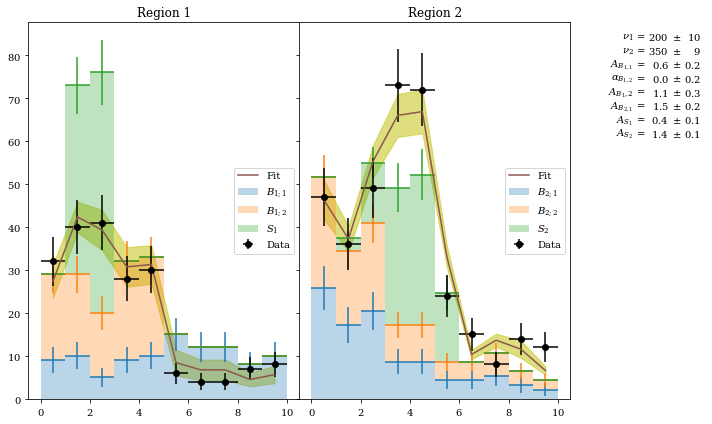

In [17]:
fig, ax = subplots(ncols=3,figsize=(10,6),sharey=True,
                   gridspec_kw={'width_ratios':(4,4,2),'wspace':0})

sca(ax[0])

sca(ax[0])
plot_channel(1,r1_x, r1_bg1_h, r1_bg2_h, r1_sg_h, r1_dt_h, r1_cf, p, cov,2,tab=False)

sca(ax[1])
plot_channel(2,r1_x, r2_bg2_h, r2_bg2_h, r2_sg_h, r2_dt_h, r2_cf, p, cov,2,tab=False)

ax[2].set_axis_off()
plot_fit_table(p,cov,ax=ax[2],
               parameters=[r'\nu_1',r'\nu_2',
                           'A_{B_{1,1}}',r'\alpha_{B_{1,2}}','A_{B_1,2}',
                           'A_{B_{2,1}}','A_{S_1}','A_{S_2}'])

fig.tight_layout()

Vi ser at vores fit kommer nogenlunde tæt på hvad vi forventer (givet de små tælletal).  I den første kanal får vi valideret vores model og vores eftersøgning af signal i den anden kanal giver et signal over baggrund på 

We see that our fit comes close to what we expect (given the small counts). In the first channel we get our model validated and our search for signal in the second channel gives a signal over background of

In [18]:
def sg_over_bg(p):
    return p[-1] / p.sum()

sel = [4,5,7]
res = format_result(sg_over_bg(p[sel]),
                    [propagate_uncertainty(sg_over_bg,
                                           p[sel],
                                           cov[sel,sel])],
                   name=r'\mu')

from IPython .core. display import Latex
display(Latex('$$'+res+'$$'))

<IPython.core.display.Latex object>

i god overensstemmelse med vores input 

in good agreement with our input

$$\frac{1}{1+1.5+1}=\frac{2}{7}\approx 0.3\quad.$$

## Blind analyse 

## Blind analysis

Der er en generel bekymring når vi udfører en analyse at vi kan komme til at udvælge data eller vælge parametre sådan at vi udvælger det resultat som vi ønsker.  For eksempel kan vi vælge data sådan at vi ser et klart signal over baggrund, eller vælge områder at lave tilpasning i sådan at en parameter får den "søgte" værdi, selvom en mere inklusiv analyse ville give et andet resultat. 

Én måde undgå sådanne, oftest ubevidste, subjektive skævvridninger i vores analyse er at udfører en _blind analyse_.  Med blind analyse mener vi at vi ikke kender det endelige resultat indtil vi har udført praktisk talt alle tjek.  Vi kan foreksempel udfører hele vores analyse på simuleret data, og først når vi er klar udfører analysen på data.  

Vi kan også have den privilegie at vi kan indele vores data i flere separate områder (kanaler) hvor det signal eller parameter vi er intresseret i er isoleret i en eller flere kanaler, mens andre kanaler består hovedsagligt af baggrund som muligvis er kendt.   Disse områder som formodes ikke at indholde signalet kaldes _sidebånd_ (engl _side bands_). I den situation kan vi udfører første del af vores analyse sådan at vi finder den bedste beskrivelse af baggrunden i sidebåndene.  Når vi er klar udvider vores analyse med signal omåderne sådan at beskrivelsen fra side båndene bliver brugt i signal områderne. 

I en sådan situation vil man udfører (samtidig) tilpasning over sidebånd, og når det er tilfredsstillende kan vi udvide vores tilpasning sådan at vi udfører en samtidig tilpasning over sidebånd og signal områder. 

Det er værd at bemærke et par ting omkring blind analyse.  Først og fremmest er det _god tro_ metodik.  Der er intet formelt det holder en fra at "snyde" og udfører den fulde analyse andet end aftalen om at lade være eller eksterne tekniske begrænsninger.  Der er heller ikke nogen statistisk teori eller metodik der sikre at der stadig ikke kan forekomme subjektive skævvridninger.  Når det er sagt, er det en simpel og sund tilgang til analyse der forsøger at minimere potentielle problemer. 

There is a general concern when we perform an analysis that we can select data or select parameters so that we select the result that we want. For example, we can select data such that we see a clear signal over background, or choose areas to adjust in such a way that a parameter take on the "wanted" value, although a more inclusive analysis would produce a different result.

One way to avoid such, most often unconscious, subjective biases in our analysis is to perform a _blind analysis_. By blind analysis we mean that we do not know the final result until we have performed virtually all checks. For example, we can perform our entire analysis on simulated data, and only when we are ready do the analysis on data.

We may also have the privilege of dividing our data into several separate areas (channels) where the signal or parameter we are interested in is isolated in one or more channels, while other channels consist mainly of backgrounds, which may be known. These areas that are not supposed to contain the signal are called _sidebands_. In this situation, we can perform the first part of our analysis so that we find the best description of the background in the side bands. When we are ready, we expand our analysis with the signal regions such that the description from the side bands is used in the signal channels.

In such a situation one will perform (simultaneous) fits over sidebands, and when that analysis is satisfactory we can extend our analysis so that we perform simultaneous fit across sidebands and signal areas.

It is worth noting a few things about blind analysis. First of all, it is _good faith_ methodology. There is nothing formal that keeps one from "cheating" and perform the full analysis, other than the agreement not to do so, or external technical restrictions. Nor is there any statistical theory or methodology to ensure that subjective biases still do not occur. That said, it is a simple and healthy approach to analysis that tries to minimize potential problems.

## Opsummering

## Summary

Vi har udvilket funktionen `simul_mle_fit` til at udfører en samtidig tilpasning over flere regioner (eller kanaler).  Vi har set hvorledes at vi kan bruge dette til at modelerer f.eks. signal over baggrund i flere kanaler med henblik på at validerer med kendte signaler eller lignende. 

We have developed the function `simul_mle_fit` to perform simultaneous fitting across multiple regions (or channels). We have seen how we can use this to model e.g., signal over background in multiple channels for validation with known signals or the like.

In [19]:
simul_mle_fit.__doc__=\
    """Perform simulatinous MLE fit over several regions

    This will fit a combined function to data in several regions.  
    
    Each region has it's own data and it's own model function.  The kind 
    of MLE to do in each region can also be customized. 
    
    Parameters
    ----------
    regions : sequence of containers 
        A sequence of regions.  Each region is specified as 
        
        data : array-like, (array-like,array-like)
            Data for the region (either observations, or a binned data)
        func : callable 
            Function to model the data in the region.  Note, all 
            functions receive all parameters (except extended overall scaling).  
            It is up to the user to extract the needed parameters for a given 
            region 
        kw : dict (optional)
            Additional keyword arguments to pass to the logarithmic 
            likelihood function (either `binned_llh` or `llh`).  These 
            update the general keywords passed to `simul_mle_fit` 
            
    p0 : array-like 
        Initial parameters.  This must be _all_ parameters used in the 
        fit.  Extended scale parameters must come first in the container. 
        
        Note, all functions in all regions receive _all_ parameters 
        (except the extended scale parameters), and it is up to the 
        user to filter out hte relevant parameters for a given region.
        
    *args : tuple 
        Additional arguments 
        
    **kwargs : dict 
        Keyword arguments 
        
        extended : bool 
            Perform an extended MLE
        logpdf : bool 
            If the functions are logarithmic PDFs pass True for this
        normalized : bool 
            If we're doing extended fits, and the PDFs are not normalised
            pass False for this. Has no effect for Poisson binned fits. 
        xtra : callable
            Extra stuff to add to logarithmic PDF
        density : bool, int, float 
            For binned likelihood fits. 
        cdf : bool 
            For binned likelihood fits
        poisson : bool 
            For binned likelihood fits. 
        raw_n : array-like 
            Cached calculation of raw count equivalent 
        log_Gamma_Nn : float 
            Cached calculation of binned corrections 
            
        Other arguments are passed to `scipy.optimize.minimize`
    
    Returns
    -------
    p : array-like 
        Found parameter values (including possibly extended normalisations)
    cov : array-like 
        Covariance of parameters 
    opt : OptimizeResult (optional)
        If `full_output=True` is passed, also get full result 
        from `minimize`. 
    

    See also 
    --------
    mle_fit, llh, binned_llh, plot_fit, plot_nsigma_contour, fit 
    """